<a href="https://colab.research.google.com/github/archit436/Birds_Classifier/blob/main/Models/Main_Models/Main_Model_Audio_Main_File.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


0. Setup


In [1]:
# Start by importing the relevant libraries.
# Copied from Archit's Lab 3 Submission and then some more.
import os
import glob
import pandas as pd
import numpy as np
import pickle
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
from collections import Counter
from torch.utils.data import TensorDataset, DataLoader, ConcatDataset, Subset
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

1. Data Processing - WAV Tensors Spectograms


In [23]:
# Start by loading the birds dataframe for deets on birds to classify.
birds_df = pd.read_csv('../../Data Processing/chosen_classes_47_data_stats.csv')
birds_df.head()

,Index,Class ID,Images Count,XC Recordings Count,Species Name,XC Species Name
0,0,315,116,169,Gadwall (Breeding male),Gadwall
1,1,317,120,243,Mallard (Breeding male),Mallard
2,2,352,120,283,Black-crowned Night-Heron (Adult),Black-crowned Night Heron
3,3,400,117,335,Herring Gull (Adult),Herring Gull
4,4,450,120,365,Common Tern,Common Tern


In [28]:
# Start by importing the tensors stored in the .pt files, one for each class.
# Define the directory of the audio data.
wav_tensors_dir = '../../Data/Xeno_Canto_WAV_Spectrograms_10sec'
# Define a list to store the tensors and associated labels.
all_features = []
all_labels = []

# Iterate through each bird, importing only the ones in birds_df.
for file in os.listdir(wav_tensors_dir):
    # Check if the file is a .pt file.
    if(file.endswith('.pt') == False):
        continue
    # Load the pt file.
    pt_file = glob.glob(os.path.join(wav_tensors_dir, file))
    # Error check
    if(pt_file == []):
        continue
    # Extract features and create labels in tensors.
    features_tensor = torch.load(pt_file[0])
    label_value = int(os.path.splitext(file)[0])
    labels_tensor = torch.full((features_tensor.shape[0],), label_value, dtype=torch.long)
    # Check if the label is in the birds_df dataframe.
    if label_value not in birds_df['Class ID'].values:
        continue
    # Add these tensors to their respective lists.
    all_features.append(features_tensor)
    all_labels.append(labels_tensor)
    print(f"Bird {label_value} loaded with {features_tensor.shape[0]} samples.")

/var/folders/s8/7wj664s92gx_89p1xhcwbq800000gn/T/ipykernel_10841/4054560578.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  features_tensor = torch.load(pt_file[0])


Bird 539 loaded with 170 samples.
Bird 352 loaded with 285 samples.
Bird 317 loaded with 240 samples.
Bird 979 loaded with 331 samples.
Bird 848 loaded with 181 samples.
Bird 949 loaded with 150 samples.
Bird 877 loaded with 284 samples.
Bird 774 loaded with 211 samples.
Bird 802 loaded with 500 samples.
Bird 847 loaded with 210 samples.
Bird 832 loaded with 500 samples.
Bird 513 loaded with 351 samples.
Bird 946 loaded with 175 samples.
Bird 527 loaded with 335 samples.
Bird 536 loaded with 500 samples.
Bird 957 loaded with 223 samples.
Bird 543 loaded with 184 samples.
Bird 856 loaded with 500 samples.
Bird 902 loaded with 500 samples.
Bird 852 loaded with 279 samples.
Bird 796 loaded with 500 samples.
Bird 746 loaded with 208 samples.
Bird 871 loaded with 499 samples.
Bird 400 loaded with 335 samples.
Bird 830 loaded with 289 samples.
Bird 756 loaded with 261 samples.
Bird 875 loaded with 202 samples.
Bird 964 loaded with 156 samples.
Bird 886 loaded with 172 samples.
Bird 810 loade

In [29]:
# Print the number of classes for which data has been extracted.
num_classes = len(all_labels)
print(f"Number of classes for which data has been extracted: {num_classes}")

Number of classes for which data has been extracted: 47


In [30]:
# Error check for type of tensors.
all_features[0].dtype

torch.float32

In [31]:
# Concatenate all the tensors into one tensor.
features_tensor = torch.cat(all_features, dim=0)
labels_tensor = torch.cat(all_labels, dim=0)

print("Concatenation complete.")

# Encode the labels to make them suitable for training the model.
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels_tensor)
# Create mapping dictionaries for the encoding.
id_to_index = dict(zip(labels_tensor, encoded_labels))
index_to_id = dict(zip(encoded_labels, labels_tensor))

print("Encoding complete.")

# Pickle dump these mappings for use later.
with open('label_mappings.pkl', 'wb') as f:
    pickle.dump({'id_to_index': id_to_index, 'index_to_id': index_to_id}, f)

print("Mappings pickled.")

# Replace the labels tensor.
labels_tensor = torch.from_numpy(encoded_labels)

# Print out stats.
print(f"Shape of features tensor: {features_tensor.shape}")
print(f"Shape of labels tensor: {labels_tensor.shape}")

Concatenation complete.
Encoding complete.
Mappings pickled.
Shape of features tensor: torch.Size([13407, 1, 128, 128])
Shape of labels tensor: torch.Size([13407])


In [32]:
# Now we move on to splitting the data into training, validation, and test sets.
# We will use a stratified split to ensure uniform distribution of classes.

# Get labels as numpy array.
labels_np = labels_tensor.numpy()
# Use the labels np array to create indices array.
indices = np.arange(len(labels_np))

# First Split: train + val vs test - 80:20
sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
temp_idx, test_idx = next(sss1.split(indices, labels_np))

# Get the temporary set.
temp_indices = np.arange(len(temp_idx))
temp_labels_np = labels_np[temp_idx]

# Second Split: train vs val - 80:20
sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
train_temp_idx, val_temp_idx = next(sss2.split(temp_indices, temp_labels_np))

# Convert to original indices.
train_idx = temp_idx[train_temp_idx]
val_idx = temp_idx[val_temp_idx]

In [33]:
# Helper function to create a balanced dataset for training.
def create_balanced_dataset(full_dataset, train_idx, target_samples_per_class=500):
    """
    Create a balanced dataset by oversampling minority classes to reach the target number of samples.
    
    Args:
        full_dataset: The complete dataset
        train_idx: Indices of training samples
        target_samples_per_class: Target number of samples for each class (default: 500)
        
    Returns:
        Balanced training dataset
    """
    # Create initial subset with training indices
    initial_train_dataset = Subset(full_dataset, train_idx)
    
    # Extract labels for all training samples
    train_labels = []
    for idx in train_idx:
        _, label = full_dataset[idx]  # Assuming dataset returns (data, label)
        train_labels.append(label.item())
    
    # Count samples per class
    class_counts = Counter(train_labels)
    print(f"Original class distribution: {dict(class_counts)}")
    
    # Identify classes that need oversampling
    classes_to_oversample = {cls: target_samples_per_class - count 
                             for cls, count in class_counts.items() 
                             if count < target_samples_per_class}
    
    if not classes_to_oversample:
        print("No oversampling needed - all classes have enough samples")
        return initial_train_dataset
    
    # Group indices by class
    class_indices = {cls: [] for cls in class_counts.keys()}
    for i, idx in enumerate(train_idx):
        class_indices[train_labels[i]].append(idx)
    
    # Create oversampled indices
    additional_indices = []
    
    for cls, num_needed in classes_to_oversample.items():
        cls_indices = class_indices[cls]
        # Randomly sample with replacement from the class
        oversampled_indices = np.random.choice(cls_indices, size=num_needed, replace=True)
        additional_indices.extend(oversampled_indices)
    
    # Combine original indices with oversampled indices
    all_indices = list(train_idx) + additional_indices
    
    # Create final balanced dataset
    balanced_train_dataset = Subset(full_dataset, all_indices)
    
    # Verify the new distribution
    balanced_labels = []
    for idx in all_indices:
        _, label = full_dataset[idx]
        balanced_labels.append(label.item())
    
    balanced_counts = Counter(balanced_labels)
    print(f"Balanced class distribution: {dict(balanced_counts)}")
    
    return balanced_train_dataset

In [34]:
# Create a full dataset combining the features and labels tensors.
full_dataset = TensorDataset(features_tensor, labels_tensor)

In [44]:
# Create subset datasets using the split indices.
# train_dataset = create_balanced_dataset(full_dataset, train_idx, target_samples_per_class=500)
train_dataset = torch.utils.data.Subset(full_dataset, train_idx)
val_dataset = torch.utils.data.Subset(full_dataset, val_idx)
test_dataset = torch.utils.data.Subset(full_dataset, test_idx)

2. CNN Implementation for Spectrograms


In [36]:
"""FOR MACBOOK LOCAL SETUP USERS ONLY """
use_mps = True
# Set device to GPU if available
device = torch.device("mps") if use_mps and torch.backends.mps.is_available() else torch.device("cpu")

In [38]:
class SpecCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SpecCNN, self).__init__()
        self.name = "Spec_WAV_10_CNN_3"
        
        # Input shape is [batch_size, 1, 128, 128]
        
        # First convolutional layer with larger kernel for initial feature detection
        self.conv1 = nn.Conv2d(1, 64, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm2d(64)
        
        # Second convolutional layer with moderate kernel
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        
        # Third convolutional layer with smaller kernel for detailed features
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        
        # Pooling layers
        self.pool = nn.MaxPool2d(2, 2)
        
        # After 3 pooling operations, 128x128 -> 16x16
        fc_input_size = 16 * 16 * 256
        
        # Fully connected layers
        self.fc1 = nn.Linear(fc_input_size, 1024)
        self.bn_fc1 = nn.BatchNorm1d(1024)
        self.dropout1 = nn.Dropout(0.3)
        
        self.fc2 = nn.Linear(1024, num_classes)
        
    def forward(self, x):
        # First block - larger kernel
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        
        # Second block - medium kernel
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        
        # Third block - smaller kernel
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        
        # Flatten for fully connected layers
        x = x.reshape(x.size(0), -1)
        
        # Fully connected part
        x = F.relu(self.bn_fc1(self.fc1(x)))
        x = self.dropout1(x)
        x = self.fc2(x)
        
        return x

In [39]:
# Helper function to create a name for each model on the basis of its hyperparameters.
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

In [40]:
def train_net(model, batch_size, train_loader, val_loader, learning_rate=0.001, num_epochs=20):
    print(f"Now training model with spec: {model.name}")

    # Fixed PyTorch random seed for reproducibility
    torch.manual_seed(1000)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    # Optional - define a scheduler for the learning rate
    print("Loss Function, Optimizer, and Scheduler set up.")

    # Arrays to store accuracy metrics
    train_acc = np.zeros(num_epochs)
    val_acc = np.zeros(num_epochs)

    # Create an output folder for performance files
    output_folder = "Audio_Model_Performance"
    os.makedirs(output_folder, exist_ok=True)

    # Early Stopping to prevent overfitting
    best_val_acc = 0.0
    patience = 5
    patience_counter = 0

    start_time = time.time()
    print("Training Started.")

    # Iterate for number of epochs.
    for epoch in range(num_epochs):
        # --- Training Phase ---
        model.train()
        # Forwards and backwards pass for each batch
        for _, data in enumerate(train_loader, 0):
            recordings, labels = data
            recordings = recordings.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(recordings)
            loss = criterion(outputs, labels)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)  # clip gradients to prevent exploding gradients (LSTM)
            optimizer.step()
        
        print(f"Finished adjusting parameters for epoch {epoch + 1}")

        # --- Evaluation Phase ---
        model.eval()
        correct_t, total_t = 0, 0
        correct_v, total_v = 0, 0
        val_loss = 0.0
        
        # Calculate training accuracy
        with torch.no_grad():
            # Forward pass for each batch
            for recordings, labels in train_loader:
                recordings = recordings.to(device)
                labels = labels.to(device)
                output = model(recordings)
                pred = output.max(1, keepdim=True)[1]
                correct_t += pred.eq(labels.view_as(pred)).sum().item()
                total_t += recordings.shape[0]
        # Calculate training accuracy        
        train_acc[epoch] = correct_t / total_t

        # Calculate validation accuracy and loss
        with torch.no_grad():
            # Forward pass for each batch
            for recordings, labels in val_loader:
                recordings = recordings.to(device)
                labels = labels.to(device)
                output = model(recordings)
                loss_val = criterion(output, labels)
                val_loss += loss_val.item()  # accumulate loss
                pred = output.max(1, keepdim=True)[1]
                correct_v += pred.eq(labels.view_as(pred)).sum().item()
                total_v += recordings.shape[0]
        # Calculate validation accuracy and loss.        
        val_acc[epoch] = correct_v / total_v
        val_loss /= len(val_loader)  # average validation loss
        
        # Update the learning rate based on validation loss.
        # scheduler.step(val_loss)
        
        # Print epoch results including validation loss.
        print(f"Epoch {epoch + 1}: Train acc: {train_acc[epoch]:.4f}, "
              f"Validation acc: {val_acc[epoch]:.4f}")
        
        # Early Stopping
        # Case 1: Validation accuracy has increased.
        if val_acc[epoch] > best_val_acc:
            # Reset the parameters.
            best_val_acc = val_acc[epoch]
            patience_counter = 0
        # Case 2: Validation accuracy has not increased.
        else:
            patience_counter += 1
        # Check if patience has been exceeded.
        if patience_counter > patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break

    print('Finished Training')
    elapsed_time = time.time() - start_time
    
    # Save metrics to CSV
    model_filename = get_model_name(model.name, batch_size, learning_rate, num_epochs - 1)
    model_path = os.path.join(output_folder, model_filename)
    train_acc_path = f"{model_path}_train_acc.csv"
    val_acc_path = f"{model_path}_val_acc.csv"
    np.savetxt(train_acc_path, train_acc[:epoch + 1])
    np.savetxt(val_acc_path, val_acc[:epoch + 1])
    
    return train_acc[:epoch + 1], val_acc[:epoch + 1]

In [45]:
# Create data loaders using the feature extraction wrapper.
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Now training model with spec: Spec_WAV_10_CNN_3
Loss Function, Optimizer, and Scheduler set up.
Training Started.
Finished adjusting parameters for epoch 1
Epoch 1: Train acc: 0.1664, Validation acc: 0.1445
Finished adjusting parameters for epoch 2
Epoch 2: Train acc: 0.1917, Validation acc: 0.1585
Finished adjusting parameters for epoch 3
Epoch 3: Train acc: 0.2020, Validation acc: 0.1604
Finished adjusting parameters for epoch 4
Epoch 4: Train acc: 0.2064, Validation acc: 0.1641
Finished adjusting parameters for epoch 5
Epoch 5: Train acc: 0.2146, Validation acc: 0.1669
Finished adjusting parameters for epoch 6
Epoch 6: Train acc: 0.2161, Validation acc: 0.1636
Finished adjusting parameters for epoch 7
Epoch 7: Train acc: 0.2170, Validation acc: 0.1664
Finished adjusting parameters for epoch 8
Epoch 8: Train acc: 0.2155, Validation acc: 0.1636
Finished adjusting parameters for epoch 9
Epoch 9: Train acc: 0.2164, Validation acc: 0.1674
Finished adjusting parameters for epoch 10
Epoch 

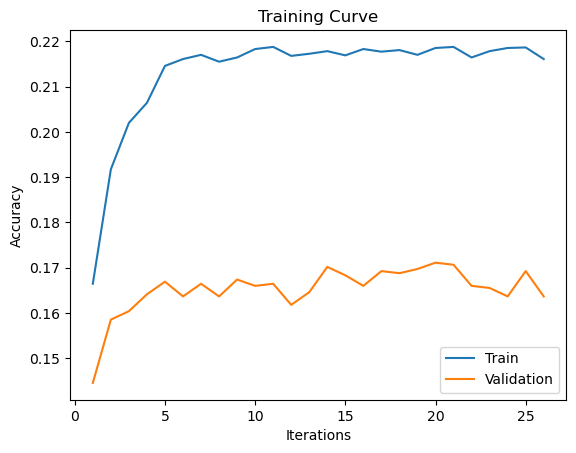

In [46]:
# Create an instance of the model.
model = SpecCNN()

# Move the model to GPU if available.
model.to(device)

# Train the model
train_acc, val_acc = train_net(model, batch_size, train_loader, val_loader,
                                   learning_rate = 0.001, num_epochs = 30)
n = len(train_acc)
plt.title("Training Curve")
plt.plot(range(1,n+1), train_acc, label="Train")
plt.plot(range(1,n+1), val_acc, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.show()